In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from segmentation_models_pytorch.losses import DiceLoss
from tqdm import tqdm
from torchvision.utils import save_image

from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor

/home/user20/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

# if device.type == "cuda":
#     # use bfloat16 for the entire notebook
#     torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
#     # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
#     if torch.cuda.get_device_properties(0).major >= 8:
#         torch.backends.cuda.matmul.allow_tf32 = True
#         torch.backends.cudnn.allow_tf32 = True

using device: cuda:0


In [3]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def show_image(image_array):
    if isinstance(image_array, torch.Tensor):
        plt.imshow(image_array.numpy())
    elif isinstance(image_array, np.ndarray):
        plt.imshow(image_array)
    else:
        raise NotImplementedError("Image format not supported")
    plt.axis('off')
    plt.title('Image')
    plt.show()

In [4]:
def build_sam2_image_predictor(sam2_checkpoint="../../checkpoints/sam2_hiera_tiny.pt", model_cfg="sam2_hiera_t.yaml"):
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

    predictor = SAM2ImagePredictor(sam2_model)

    for param in predictor.model.parameters():
        param.requires_grad = False
    
    return predictor

def get_mask_logo(resize_to_shape, logo_path='../images/airi_logo.jpg'):
    airi_logo = Image.open(logo_path)
    airi_logo = np.array(airi_logo.convert("RGB"))

    airi_logo = Image.fromarray(airi_logo)
    airi_logo = airi_logo.resize(resize_to_shape) # transformed_image.shape[1:][::-1]

    airi_logo = np.array(airi_logo)
    airi_logo[airi_logo <= 200] = 1
    airi_logo[airi_logo > 200] = 0

    airi_logo = np.any(airi_logo, axis=2)
    airi_logo = airi_logo[None, ...]
    airi_logo = torch.from_numpy(airi_logo)
    airi_logo = airi_logo.to(device=device, dtype=torch.float32)

    return airi_logo

def get_image_predict(predictor, image, input_point, input_label=np.array([1])):
    predictor.set_image(image)
    return predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
        return_logits=True,
    )

In [5]:
def train_init(image_path):
    initial_image = Image.open(image_path)

    epsilon = torch.tensor(7.5/255, dtype=torch.float32, device=device)

    tensor_initial_image = ToTensor()(initial_image)
    tensor_initial_image = tensor_initial_image.to(device=device)

    delta = torch.zeros_like(tensor_initial_image, requires_grad=True)

    return tensor_initial_image, delta, epsilon

def save_adv_image(predictor, initial_image, delta, epsilon, input_point, input_label, adv_image_path="asd", delta_image_path="asd"):
    adv_mask = get_mask_logo(resize_to_shape=initial_image.shape[1:][::-1])
    opt = optim.Adam([delta], lr=0.01)

    dice_loss = DiceLoss('binary', from_logits=True)

    losses = []
    for t in tqdm(range(600)):
        opt.zero_grad()
        predictor.set_image(initial_image + delta)
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
            return_logits=True,
        )
        loss = dice_loss(masks, adv_mask)

        losses.append(loss.item())
        
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    adv_image = (initial_image + delta).detach().cpu().clip(0, 1)

    save_image(adv_image, adv_image_path)
    save_image(delta.detach().cpu().clip(0, 1), delta_image_path)
    
    return losses, adv_image

def save_image_with_mask(image: Image, mask: np.ndarray, out_image_path, alpha=0.7):
    image = (np.array(image) / 255.).transpose(2, 0, 1)
    mask = np.stack([mask[0] * 87./255, mask[0] * 186./255, mask[0] * 168./255])

    image_transparency = (image * (1 - alpha) + mask * alpha).clip(0, 1)

    image = np.where(mask, image_transparency, image).clip(0, 1)
    image = Image.fromarray((image.transpose(1, 2, 0) * 255).astype(dtype=np.uint8))

    # tmp_name = (tmp + str(counter))[-5:]
    # image.save(f"./videos/adv_bedroom_with_mask/{tmp_name}.png")
    image.save(out_image_path)

def sample_mean_cov(image_size):
    x_segment = (image_size[0] * 0.1, image_size[0] * 0.9)
    y_segment = (image_size[1] * 0.1, image_size[1] * 0.9)
    means = [
        np.array([x_segment[0] + (x_segment[1] - x_segment[0]) * 0.5, y_segment[0] + (y_segment[1] - y_segment[0]) * 0.5], dtype=np.float32),
        np.array([x_segment[0], y_segment[0]]),
        np.array([x_segment[0] + (x_segment[1] - x_segment[0]) * 0.5, y_segment[0]], dtype=np.float32),
        np.array([x_segment[1], y_segment[0]], dtype=np.float32),
        np.array([x_segment[0], y_segment[0] + (y_segment[1] - y_segment[0]) * 0.5], dtype=np.float32),
        np.array([x_segment[1], y_segment[0] + (y_segment[1] - y_segment[0]) * 0.5], dtype=np.float32),
        np.array([x_segment[0], y_segment[1]], dtype=np.float32),
        np.array([x_segment[0] + (x_segment[1] - x_segment[0]) * 0.5, y_segment[1]], dtype=np.float32),
        np.array([x_segment[1], y_segment[1]], dtype=np.float32),
    ]
    covs = [np.array([[image_size[0] // 3, 0], [0, image_size[1] // 3]], dtype=np.float32) for _ in range(9)]
    pis = np.array([0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    acc_pis = [np.sum(pis[:i]) for i in range(1, len(pis)+1)]
    assert np.isclose(acc_pis[-1], 1)
    # sample uniform
    r = np.random.uniform(0, 1)
    # select Gaussian
    k = 0
    for i, threshold in enumerate(acc_pis):
        if r < threshold:
            k = i
            break

    return means[k], covs[k]

def plot_loss(losses, loss_label):
    plt.figure(figsize=(5, 3))
    plt.plot(losses, label=loss_label)
    plt.title('Loss Plot')
    plt.xlabel('Iterations')
    plt.ylabel(f'{loss_label} plot')
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
delta, delta, epsilon = train_init('../images/truck/delta.png')
delta.min()

FileNotFoundError: [Errno 2] No such file or directory: '/home/user20/segment-anything-2/notebooks/images/truck/delta.png'

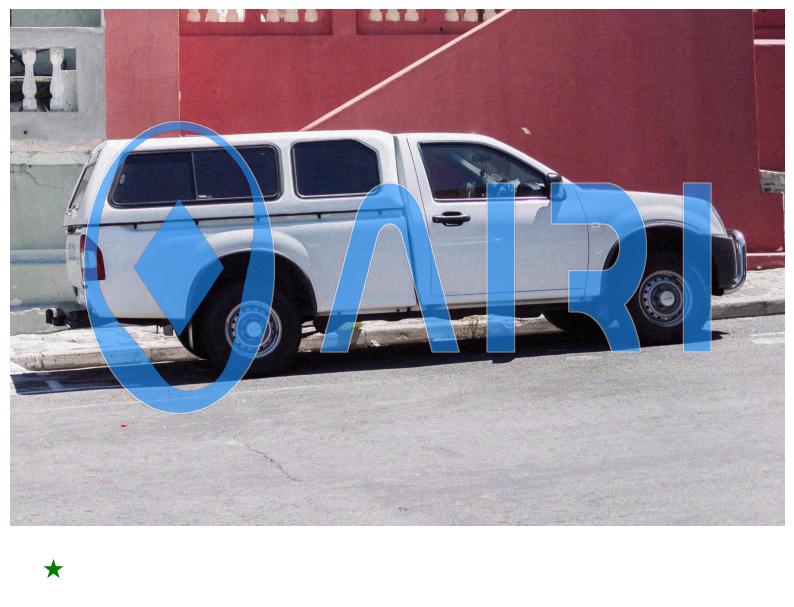

In [17]:
predictor = build_sam2_image_predictor()
adv_trunk_image = train_init('../images/truck.png')[0] + delta
input_point = np.array([[100, 1300]])
input_label = np.array([1])
masks_new, scores_new, logits = get_image_predict(predictor, initial_image, input_point)
show_masks(initial_image.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy() > 0, scores_new, input_point, None, input_label)

In [6]:
predictor = build_sam2_image_predictor()
input_point = np.array([[210, 350]])
input_label = np.array([1])
initial_image, delta, epsilon = train_init('../images/truck.jpg')

In [9]:
all_losses = {}
adv_images_truck = {}
for x in range(100, 1800, 600):
    for y in range(100, 1200, 400):
        mean, cov = sample_mean_cov(initial_image.shape)
        input_point = np.random.multivariate_normal(mean, cov, 1)
        losses, adv_image_truck = save_adv_image(predictor, initial_image, delta, epsilon, input_point, input_label, f'../images/truck/truck_{input_point[0][0]}_{input_point[0][1]}.png', '../images/truck/delta.png')
        all_losses[f'{x}_{y}'] = losses
        adv_images_truck[f'{x}_{y}'] = adv_image_truck

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [01:15<00:00,  7.94it/s]


In [2]:
adv_images_truck

NameError: name 'adv_images_truck' is not defined

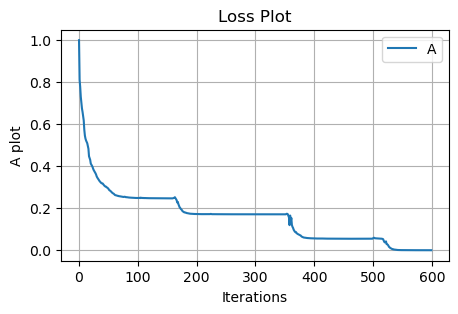

In [ ]:
plot_loss(losses, "A")

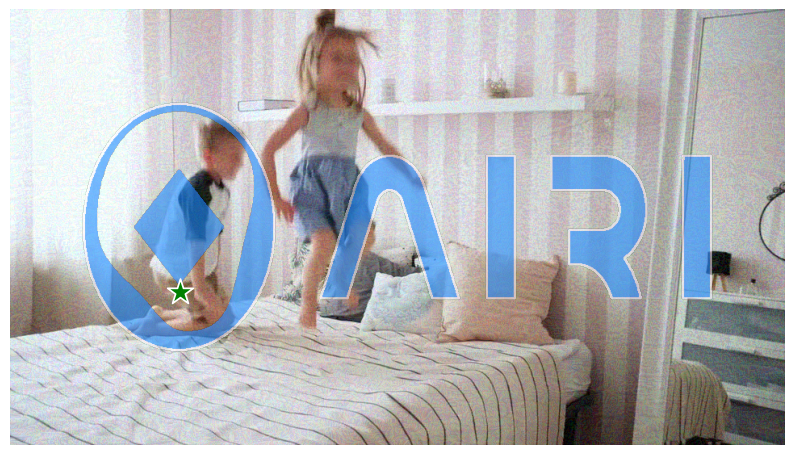

In [27]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_image_childrens, input_point, input_label)
show_masks(adv_image_childrens.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy() > 0, scores_new, input_point, None, input_label)

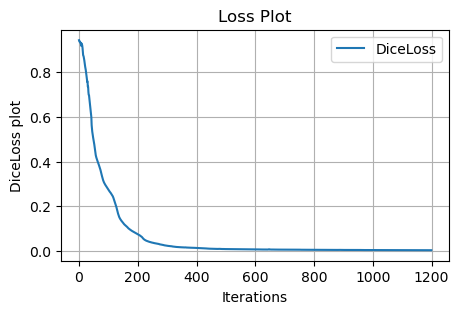

In [23]:
plot_loss(losses, 'DiceLoss')

In [25]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_image_childrens, input_point, input_label)

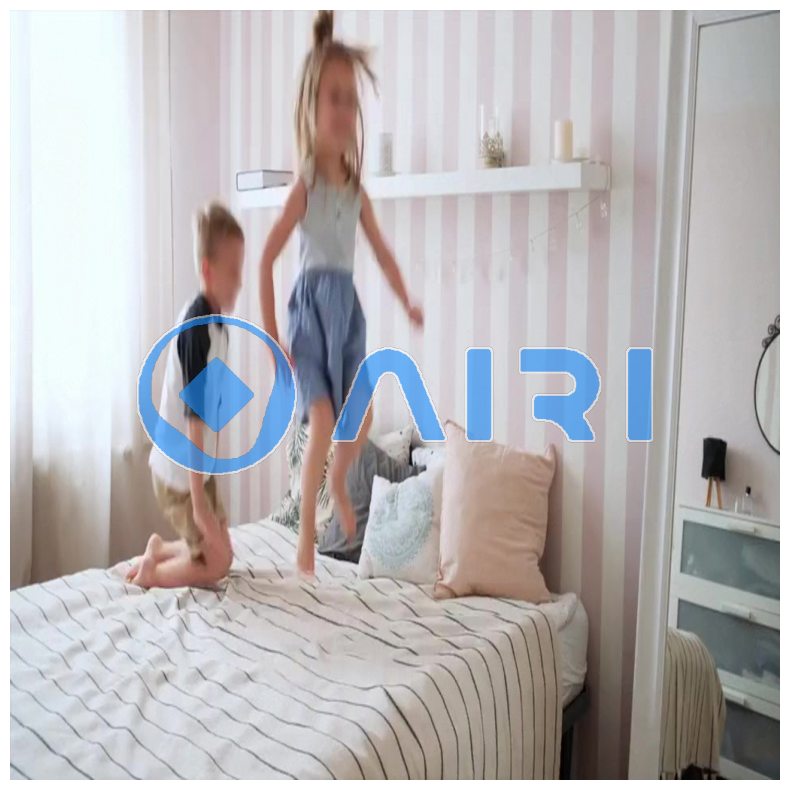

In [50]:
show_masks(adv_image_childrens.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy() > 0, scores_new)

In [51]:
adv_image_childrens.shape

torch.Size([3, 1024, 1024])

In [35]:
losses, adv_image_childrens_without_epsion = save_adv_image(predictor, '../videos/bedroom/00000.jpg', input_point, input_label, 'children_without_esposion.png')

100%|██████████| 1200/1200 [02:31<00:00,  7.94it/s]


initial_image tensor(0., device='cuda:0') tensor(1., device='cuda:0')
delta tensor(-0.0646, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0646, device='cuda:0', grad_fn=<MaxBackward1>)


In [40]:
10./255

0.0392156862745098

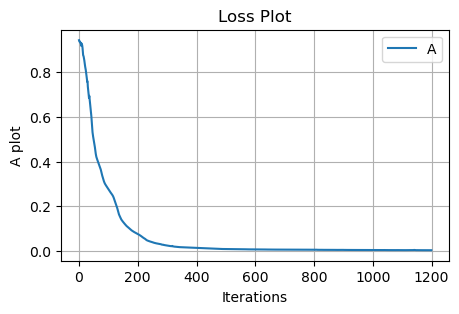

In [36]:
plot_loss(losses, "A")

In [ ]:
masks_new_wo_eps, scores_new_wo_eps, logits_wo_eps = get_image_predict(predictor, adv_image_childrens_without_epsion, input_point, input_label)

In [ ]:
show_masks(adv_image_childrens_without_epsion.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new_wo_eps.detach().cpu().numpy() > 0, scores_new_wo_eps)

In [21]:
initial_image, delta, epsilon = train_init('../images/truck.jpg')
input_point = np.array([[500, 375]])
input_label = np.array([1])
adv_mask = get_mask_logo(resize_to_shape=initial_image.shape[1:][::-1])

In [7]:
initial_image, delta, epsilon = train_init('../videos/adv_bedroom/00000.png')
input_point = np.array([[210, 350]])
input_label = np.array([1])
adv_mask = get_mask_logo(resize_to_shape=initial_image.shape[1:][::-1])

In [8]:
opt = optim.Adam([delta], lr=1e-4)

cross_entropy_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss('binary', from_logits=True)

predictor = build_sam2_image_predictor()

: 

In [23]:
losses = []

In [24]:
for t in tqdm(range(1200)):
    opt.zero_grad()
    predictor.set_image(initial_image + delta)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
        return_logits=True,
    )
    # masks = torch.sigmoid(masks)
    loss = dice_loss(masks, adv_mask)
    losses.append(loss.item())
       
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

100%|██████████| 1200/1200 [02:31<00:00,  7.94it/s]


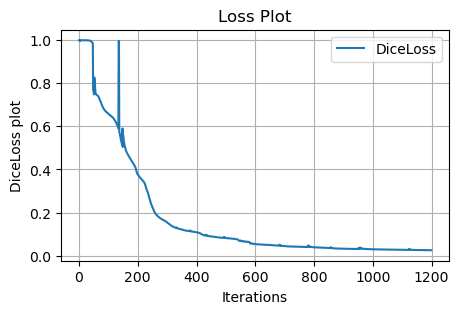

In [25]:
plot_loss(losses, 'DiceLoss')

In [32]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_image_track_from_saved, input_point, input_label)

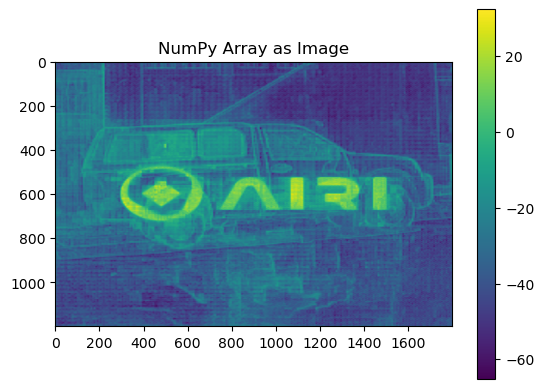

In [27]:
plt.imshow(np.squeeze(masks_new.detach().cpu().numpy()), cmap='viridis')  # You can change the colormap using the 'cmap' parameter
plt.colorbar()  # Add a colorbar to the side
plt.title("NumPy Array as Image")
plt.show()

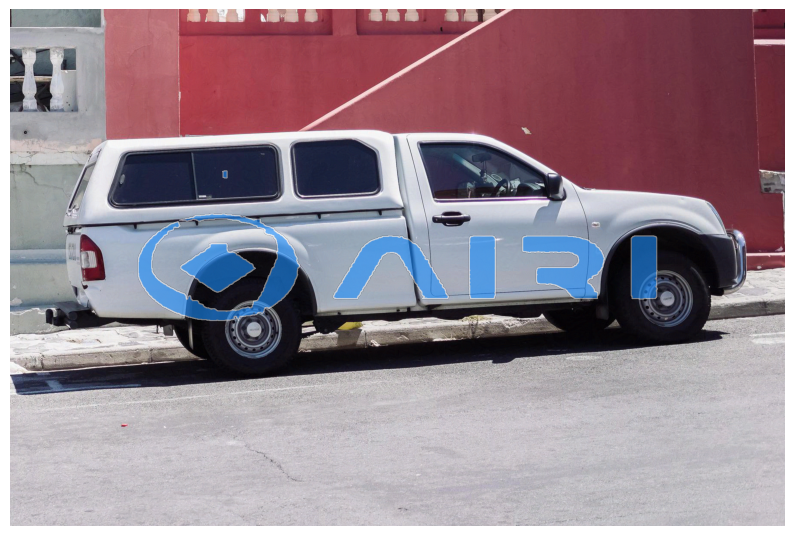

In [33]:
show_masks(adv_image_track_from_saved.detach().cpu().clip(0, 1).permute(1, 2, 0), masks_new.detach().cpu().numpy() > 0, scores_new)

In [51]:
masks_new, scores_new, logits = get_image_predict(predictor, initial_image + delta, input_point, input_label)

In [12]:
adv_image = Image.open('adv_image.png')
adv_transformed_image = torch.from_numpy(np.array(adv_image)) / 255
adv_transformed_image = adv_transformed_image.to(device=device)

In [17]:
predictor.set_image(adv_transformed_image.permute(2, 0, 1))
masks_new, scores_new, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
    return_logits=True,
)

In [14]:
adv_transformed_image.min(), adv_transformed_image.max()

NameError: name 'adv_transformed_image' is not defined

In [16]:
predictor = build_sam2_image_predictor()
points = np.array([
    [400, 300],
    [630, 300],
], dtype=np.float32)
labels = np.array([1, 1], np.int32)
losses, adv_bedroom_image = save_adv_image(predictor, '../images/groceries.jpg', points, labels, '../images/adv_images/groceries.png')

  0%|          | 4/1200 [00:00<02:31,  7.87it/s]

100%|██████████| 1200/1200 [02:29<00:00,  8.03it/s]


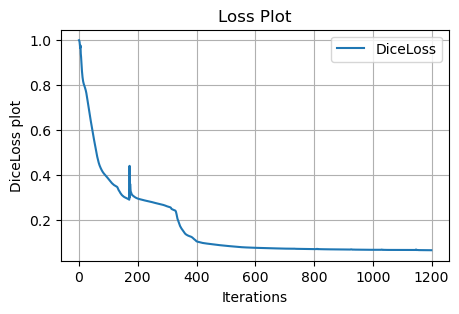

In [17]:
plot_loss(losses, 'DiceLoss')

In [18]:
predictor.set_image(adv_bedroom_image)
masks_new, scores_new, logits = predictor.predict(
    point_coords=points,
    point_labels=labels,
    multimask_output=False,
    return_logits=True,
)

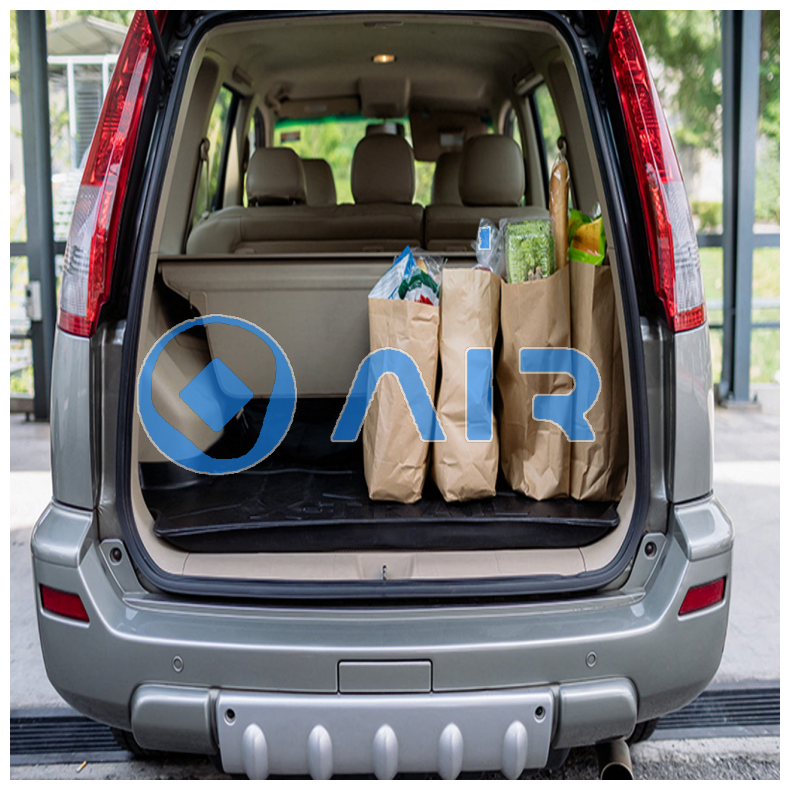

In [19]:
show_masks(adv_bedroom_image.permute(1, 2, 0).detach().cpu().numpy(), masks_new.detach().cpu().numpy() > 0, scores_new)

In [29]:
adv_bedroom_image_saved, delta, epsilon = train_init('../videos/adv_bedroom/00000.png')
adv_bedroom_image_saved = adv_bedroom_image_saved.cpu()
input_point = np.array([[224.0000, 663.7037]])
input_label = np.array([1])

In [30]:
masks_new, scores_new, logits = get_image_predict(predictor, adv_bedroom_image_saved, input_point)

In [31]:
adv_bedroom_image_saved

tensor([[[0.8902, 0.9020, 0.8980,  ..., 0.4157, 0.3922, 0.3804],
         [0.8941, 0.9137, 0.9098,  ..., 0.4157, 0.4039, 0.4000],
         [0.9020, 0.9333, 0.9255,  ..., 0.4275, 0.4314, 0.4431],
         ...,
         [0.7451, 0.7529, 0.7412,  ..., 0.1804, 0.1843, 0.1725],
         [0.7451, 0.7451, 0.7412,  ..., 0.1843, 0.1804, 0.1725],
         [0.7451, 0.7412, 0.7412,  ..., 0.1843, 0.1804, 0.1725]],

        [[0.9333, 0.9608, 0.9725,  ..., 0.4275, 0.4196, 0.4196],
         [0.9451, 0.9725, 0.9804,  ..., 0.4353, 0.4275, 0.4353],
         [0.9608, 0.9922, 0.9961,  ..., 0.4471, 0.4510, 0.4667],
         ...,
         [0.7922, 0.7961, 0.7922,  ..., 0.2000, 0.2078, 0.1922],
         [0.7922, 0.7922, 0.7922,  ..., 0.2000, 0.2000, 0.1961],
         [0.7922, 0.7922, 0.7922,  ..., 0.2000, 0.1961, 0.1961]],

        [[0.9490, 0.9843, 0.9804,  ..., 0.4471, 0.4275, 0.4235],
         [0.9608, 0.9882, 0.9843,  ..., 0.4471, 0.4392, 0.4353],
         [0.9765, 0.9961, 0.9961,  ..., 0.4549, 0.4667, 0.

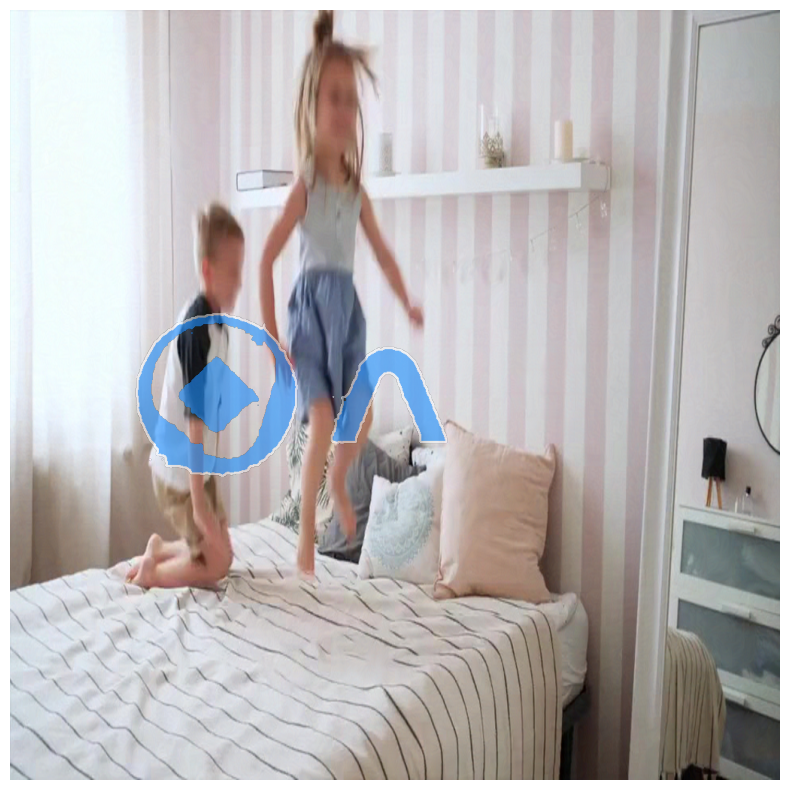

In [32]:
show_masks(adv_bedroom_image_saved.permute(1, 2, 0).detach().cpu().numpy(), masks_new.detach().cpu().numpy() > 0, scores_new)

In [56]:
adv_bedroom_image - adv_bedroom_image_saved

tensor([[[0.8868, 0.9059, 0.9020,  ..., 0.4235, 0.4032, 0.3883],
         [0.9020, 0.9367, 0.9294,  ..., 0.4388, 0.4481, 0.4536],
         [0.9020, 0.9323, 0.9326,  ..., 0.5453, 0.5546, 0.5680],
         ...,
         [0.7451, 0.7512, 0.7412,  ..., 0.1936, 0.1860, 0.1757],
         [0.7451, 0.7588, 0.7412,  ..., 0.1814, 0.1836, 0.1727],
         [0.7412, 0.7429, 0.7412,  ..., 0.1848, 0.1785, 0.1722]],

        [[0.9373, 0.9686, 0.9731,  ..., 0.4314, 0.4266, 0.4185],
         [0.9683, 1.0000, 1.0000,  ..., 0.4588, 0.4635, 0.4822],
         [0.9736, 1.0000, 1.0000,  ..., 0.5705, 0.5800, 0.5911],
         ...,
         [0.7961, 0.7961, 0.7922,  ..., 0.2083, 0.2075, 0.1983],
         [0.7917, 0.7961, 0.7922,  ..., 0.2000, 0.2084, 0.1952],
         [0.7922, 0.7922, 0.7920,  ..., 0.2003, 0.1961, 0.1946]],

        [[0.9529, 0.9843, 0.9804,  ..., 0.4388, 0.4314, 0.4275],
         [0.9804, 0.9967, 1.0000,  ..., 0.4590, 0.4766, 0.4722],
         [0.9804, 1.0000, 1.0000,  ..., 0.5762, 0.5766, 0.

In [69]:
tmp_path = '../videos/adv_bedroom/00000.jpg'
save_image(adv_image_bedroom, tmp_path)
initial_image = Image.open(tmp_path)
# initial_image = initial_image.convert("RGB")
tensor_initial_image = ToTensor()(initial_image)
# tensor_initial_image = torch.from_numpy(np.array(initial_image) / 255)
tensor_initial_image - adv_image_bedroom
# adv_image_bedroom.numpy() - tensor_initial_image.transpose(2, 0, 1)

tensor([[[-4.4768e-03, -1.1765e-02,  1.1765e-02,  ..., -1.1740e-02,
          -7.0991e-03, -1.7196e-05],
         [ 0.0000e+00, -2.2925e-02,  3.9216e-03,  ..., -7.4689e-03,
          -8.9202e-03, -1.0477e-02],
         [ 1.1765e-02, -1.0743e-02,  8.6042e-03,  ...,  7.5974e-03,
           6.2155e-03, -3.2956e-03],
         ...,
         [ 1.1765e-02,  1.7372e-03,  1.1765e-02,  ..., -5.3490e-03,
           2.2585e-03,  4.7335e-03],
         [ 1.1765e-02, -5.9012e-03,  1.1765e-02,  ...,  2.8977e-03,
          -3.2033e-03,  3.7857e-03],
         [ 1.5686e-02,  1.0078e-02,  1.1765e-02,  ..., -4.4879e-04,
          -2.0449e-03, -3.5435e-03]],

        [[ 1.9608e-02,  0.0000e+00,  3.3218e-03,  ...,  1.1765e-02,
           8.8125e-04,  1.1557e-03],
         [ 8.1739e-03, -1.1765e-02, -3.9216e-03,  ...,  3.9216e-03,
           7.1290e-03, -7.6754e-03],
         [ 1.4606e-02, -3.9216e-03,  0.0000e+00,  ...,  5.9929e-03,
           4.3094e-03, -2.8387e-03],
         ...,
         [-3.9216e-03, -7

In [45]:
# initial_image, delta, epsilon = train_init('../videos/adv_bedroom/00000.jpg')

initial_image = Image.open('../videos/adv_bedroom/00000.jpg')
# image = np.array(image.convert("RGB"))

tensor_initial_image = ToTensor()(initial_image)
tensor_initial_image = tensor_initial_image.to(device=device)

In [67]:
masks_new, scores_new, logits = get_image_predict(predictor, tensor_initial_image, np.array([[210, 350]], dtype=np.float32))

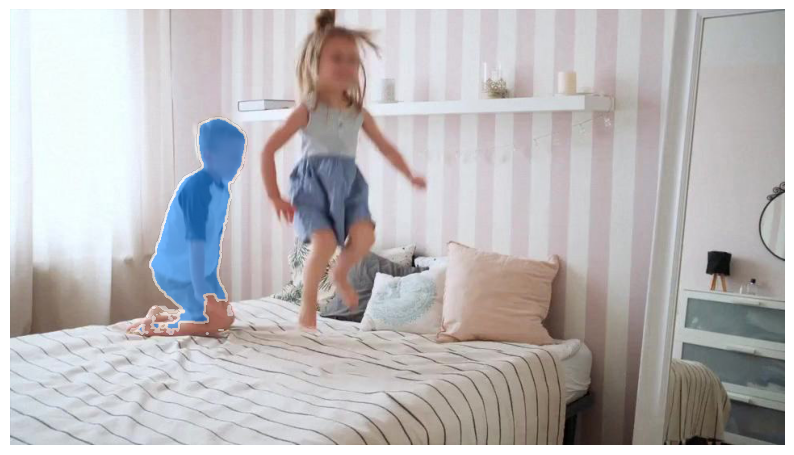

# Video

In [39]:
video_dir = "../videos/bedroom"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

In [41]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [42]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 200/200 [00:06<00:00, 31.89it/s]
